In [1]:
import mlflow
from mlflow.models import infer_signature
from mlflow import MlflowClient

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, ValidationCurveDisplay
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, make_column_transformer

from xgboost.sklearn import XGBRegressor

from src.visuals import *
from src.feature_engineering import *

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data.set_index("date", inplace = True)

Attribute Information:
date time year-month-day hour:minute:second

Appliances, energy use in Wh (target variable for prediction)

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional

In [5]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.min(), time_diffs.max()

(10.0, 10.0)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [5]:
data.describe().round(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00,19735.00
mean,97.69,3.80,21.69,40.26,20.34,40.42,22.27,39.24,20.86,39.03,19.59,50.95,7.91,54.61,20.27,35.39,22.03,42.94,19.49,41.55,7.41,755.52,79.75,4.04,38.33,3.76,24.99,24.99
std,102.52,7.94,1.61,3.98,2.19,4.07,2.01,3.25,2.04,4.34,1.84,9.02,6.09,31.15,2.11,5.11,1.96,5.22,2.01,4.15,5.32,7.40,14.90,2.45,11.79,4.20,14.50,14.50
min,10.00,0.00,16.79,27.02,16.10,20.46,17.20,28.77,15.10,27.66,15.33,29.82,-6.06,1.00,15.39,23.20,16.31,29.60,14.89,29.17,-5.00,729.30,24.00,0.00,1.00,-6.60,0.01,0.01
25%,50.00,0.00,20.76,37.33,18.79,37.90,20.79,36.90,19.53,35.53,18.28,45.40,3.63,30.02,18.70,31.50,20.79,39.07,18.00,38.50,3.67,750.93,70.33,2.00,29.00,0.90,12.50,12.50
50%,60.00,0.00,21.60,39.66,20.00,40.50,22.10,38.53,20.67,38.40,19.39,49.09,7.30,55.29,20.03,34.86,22.10,42.38,19.39,40.90,6.92,756.10,83.67,3.67,40.00,3.43,24.90,24.90
75%,100.00,0.00,22.60,43.07,21.50,43.26,23.29,41.76,22.10,42.16,20.62,53.66,11.26,83.23,21.60,39.00,23.39,46.54,20.60,44.34,10.40,760.93,91.67,5.50,40.00,6.57,37.58,37.58
max,1080.00,70.00,26.26,63.36,29.86,56.03,29.24,50.16,26.20,51.09,25.80,96.32,28.29,99.90,26.00,51.40,27.23,58.78,24.50,53.33,26.10,772.30,100.00,14.00,66.00,15.50,50.00,50.00


The dataset contains:
* General appliances' energy usage (Appliances)
* Lights' energy usage (Lights)
* Temperature and relative humidity in 8 rooms: kitchen, living room, office room, bathroom, two beedrooms, laundry room and ironing room, labeled as T1, Rh_1...T9, Rh_9 (excluding T6, RH_6 which represent temperature and humidity outside the house)
* Temperature and relative humidity outside the house (as mentioned above, and also from nearest weather station)
* Other weather data from the weather station (atmospheric pressure, windspeed, visibility, dew point).
* Two random variable (rv1, rv2) which can be used for testing

Example variable distributions are depicted below.
* T2 and RH_2 are temperature and humidity in the living room, while T5 and RH_5 - in the bathroom
* T_out, Press_mm_hg, Windspeed - data from nearest weather station
* rv1 - random variable

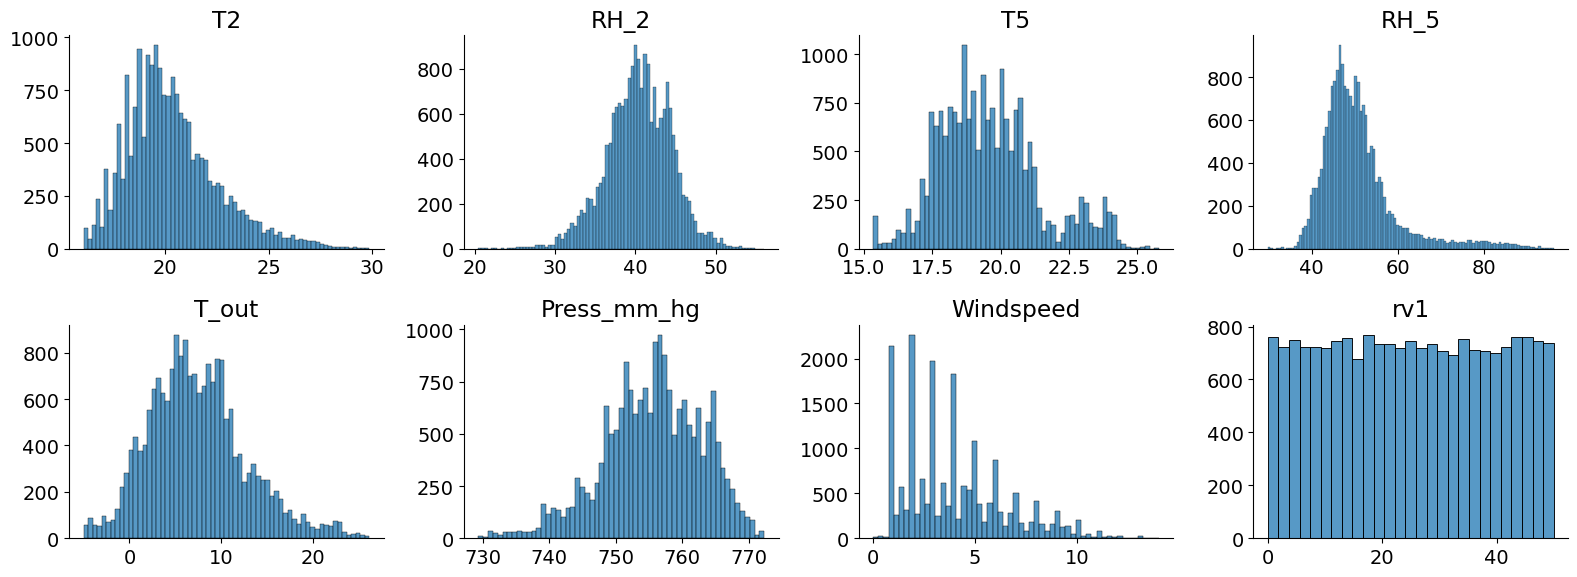

In [9]:
histplots_grid(2, 4, data, features = ["T2", "RH_2", "T5", "RH_5", "T_out", "Press_mm_hg", "Windspeed", "rv1"])

RH_6 contains information about the humidity outside the house, while RH_out provides data from the weather station. The distributions of these two variables can be seen below.

The values in RH_6 are peculiar and significantly differ from those obtained from the weather station, suggesting that a part of the measurement process might have gone wrong. For instance, there are many values at 0 and others less than 25%, which are improbable given the maritime temperate [climate of Belgium](https://en.wikipedia.org/wiki/Belgium#Geography) where such low humidity levels are virtually impossible. In contrast, the values in the RH_out variable appear more reasonable. Due to these discrepancies, it was decided to exclude the RH_6 variable and rely solely on the humidity information from RH_out.

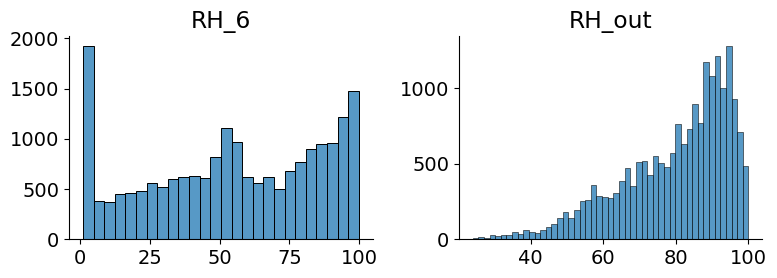

In [50]:
histplots_grid(1, 2, data, features = ["RH_6", "RH_out"])

## Energy consumption over the entire time period covered by the data

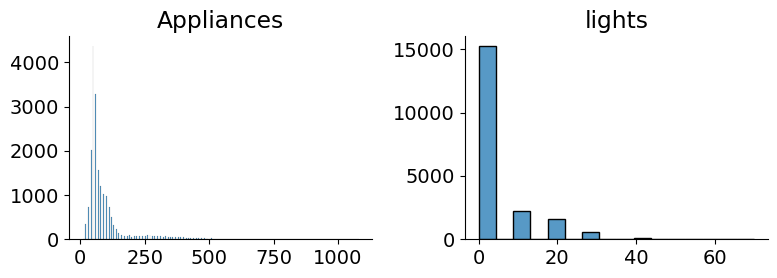

In [18]:
histplots_grid(1, 2, data, features = ["Appliances", "lights"])

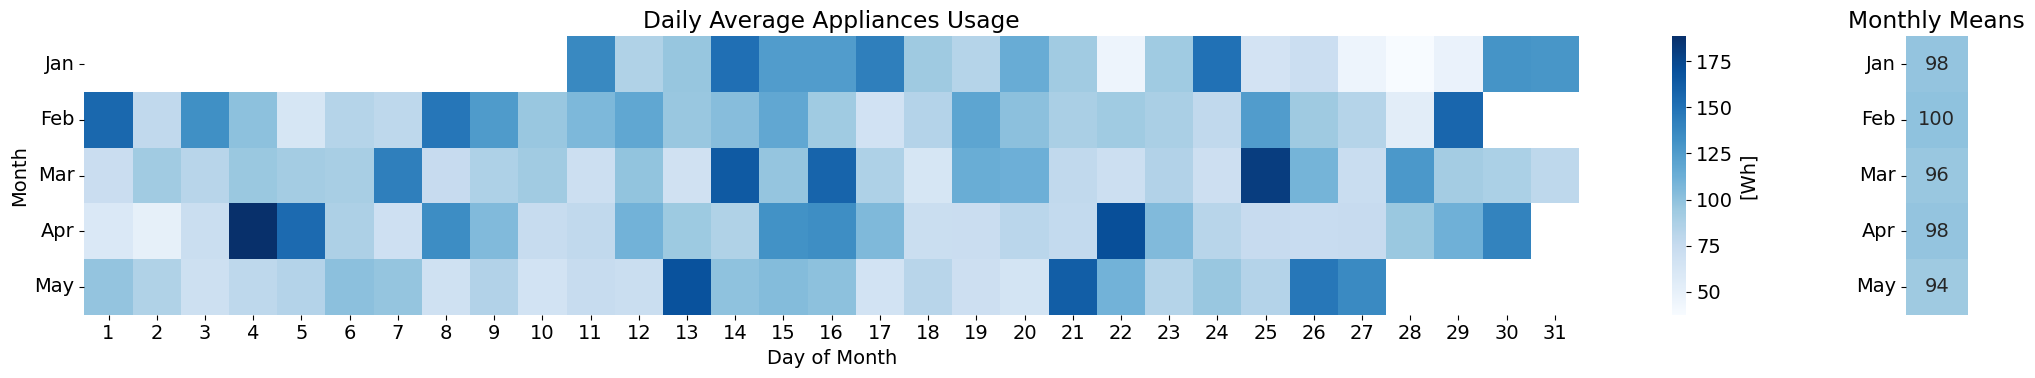

In [19]:
energy_consumption_all_time(data.Appliances)

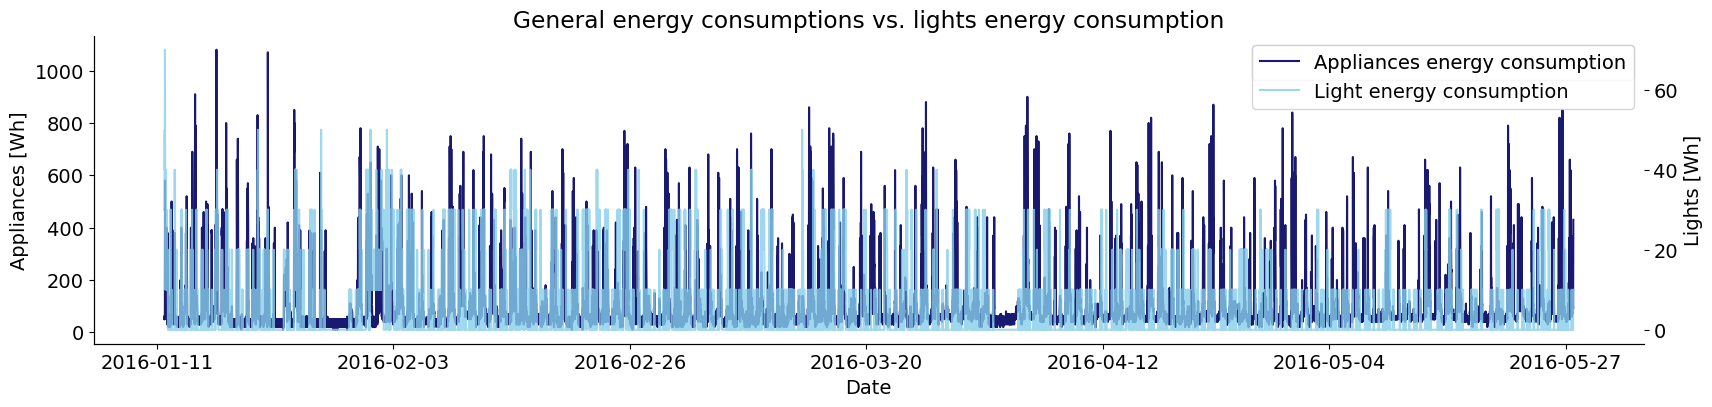

In [4]:
energy_vs_lights_plot(data.Appliances, data.lights)

## Energy consumption in smaller periods

In [4]:
enhanced_data = add_datetime_features(data)
enhanced_data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)

enhanced_data.iloc[:,-7:].head(3)

,day_of_week,hour,week_of_year,day_of_year,is_holiday,is_weekend,time_of_day
date,,,,,,,
2016-01-11 17:00:00,Monday,17,2,11,0,0,evening
2016-01-11 17:10:00,Monday,17,2,11,0,0,evening
2016-01-11 17:20:00,Monday,17,2,11,0,0,evening


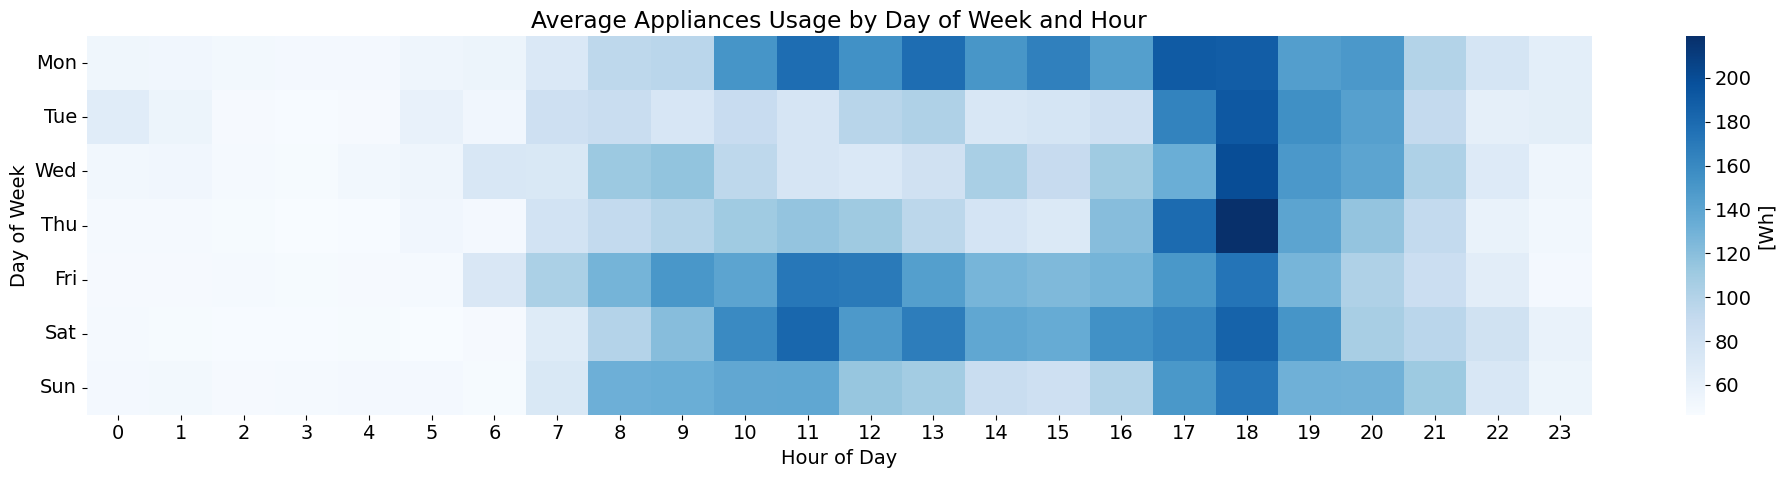

In [5]:
consumption_by_day_and_hour(enhanced_data[["Appliances", "day_of_week", "hour"]])

In [10]:
def plot_weekly_data(data, week, variables, figsize=(20, 10)):
    
    weekly_data = data[data['week_of_year'] == week]

    fig, axes = plt.subplots(len(variables), 1, figsize=figsize, sharex=True)

    for i, var in enumerate(variables):
        sns.lineplot(x=weekly_data.index, y=weekly_data[var], ax=axes[i])
        axes[i].set_title(f"{var} - Week {week}")
        axes[i].set_ylabel(var)
        axes[i].set_xlabel('')

    plt.tight_layout()
    plt.show()

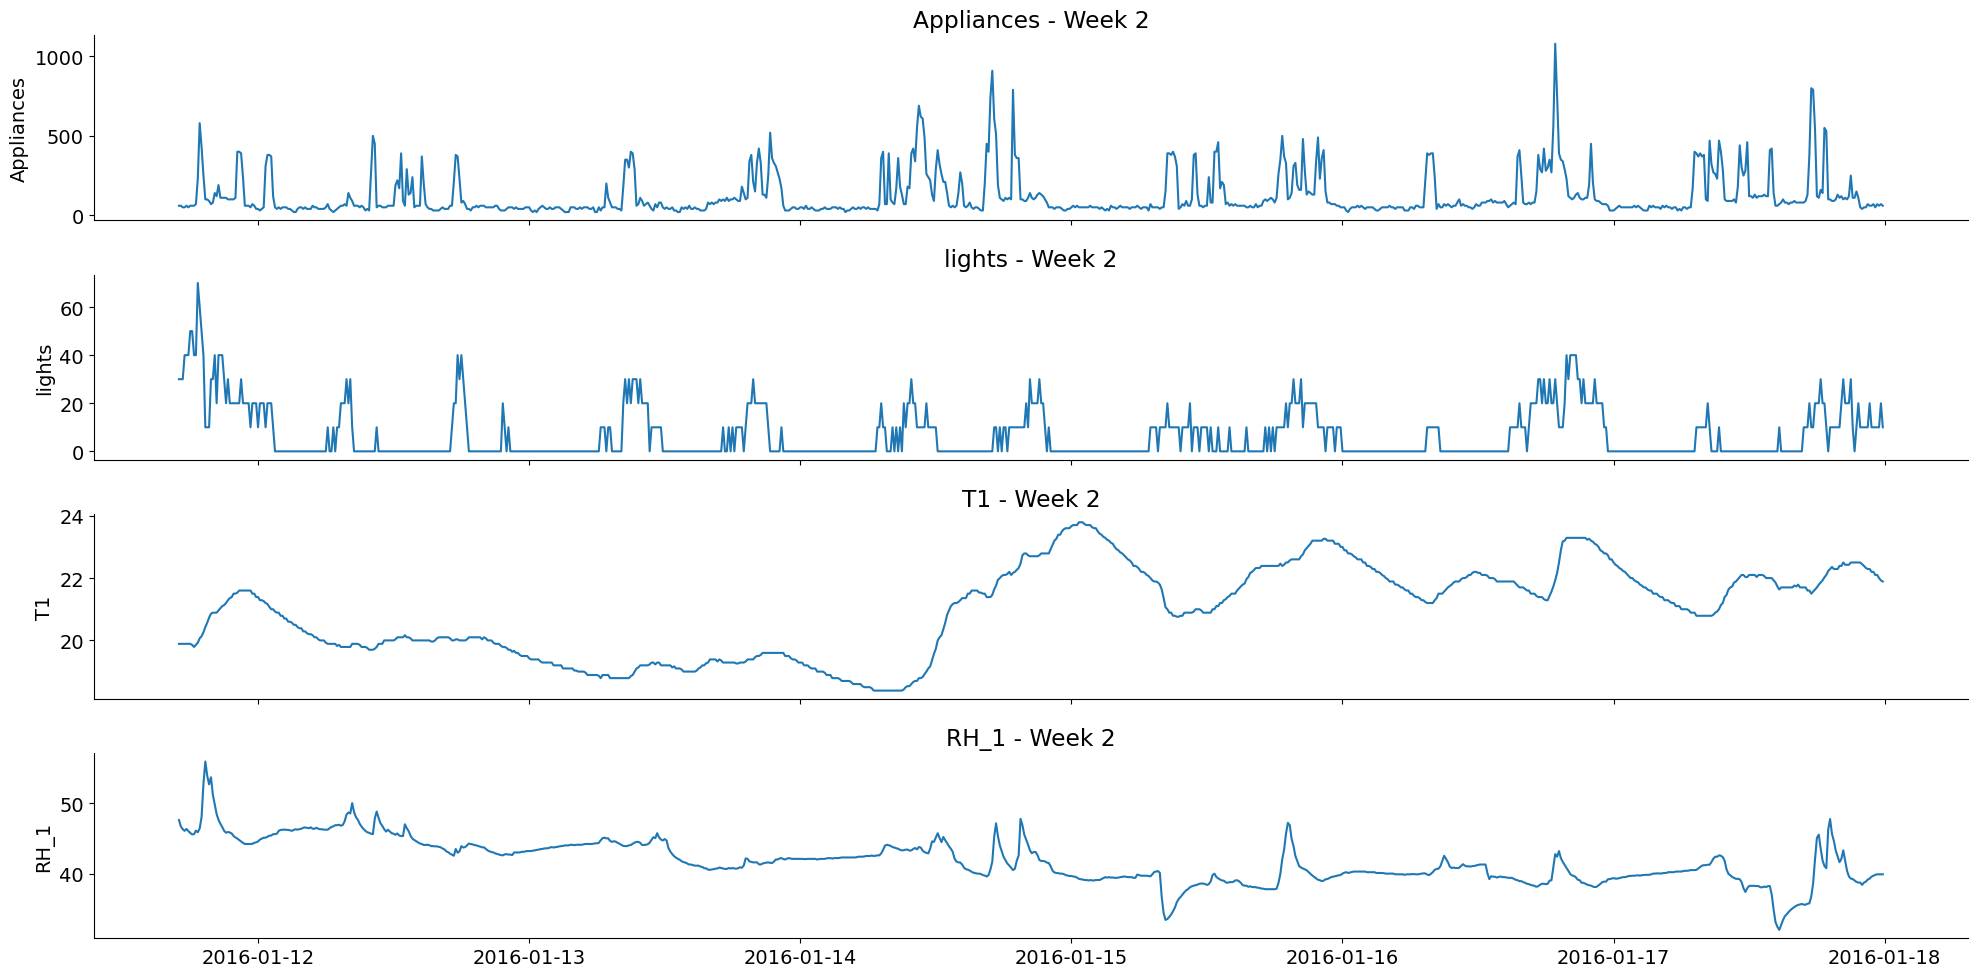

In [13]:
plot_weekly_data(enhanced_data, week=2, variables=['Appliances', 'lights', 'T1', 'RH_1'])

## Experiments

In [ ]:
data = add_lagged_features(data, lag=1, how_many=24*6)

X = data.drop("Appliances", axis = 1)
y = data.Appliances

In [351]:
n_train = int(0.9 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

mlflow.set_experiment("MLflow Energy_1")

params = {"min_samples_leaf":20, "max_features": 0.5}
model = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), 
                                              remainder="passthrough"), 
                      ExtraTreesRegressor(**params))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, y_pred)


with mlflow.start_run():

    mlflow.log_params(params)
    mlflow.log_metric("mape", mape)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "ExtraTreeRegressor, 1 exp")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="energy_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="ETR_1",
    )

In [111]:
n_train = int(0.9 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

# pipe = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), HistGradientBoostingRegressor())
model = TransformedTargetRegressor(HistGradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.18887049784440543

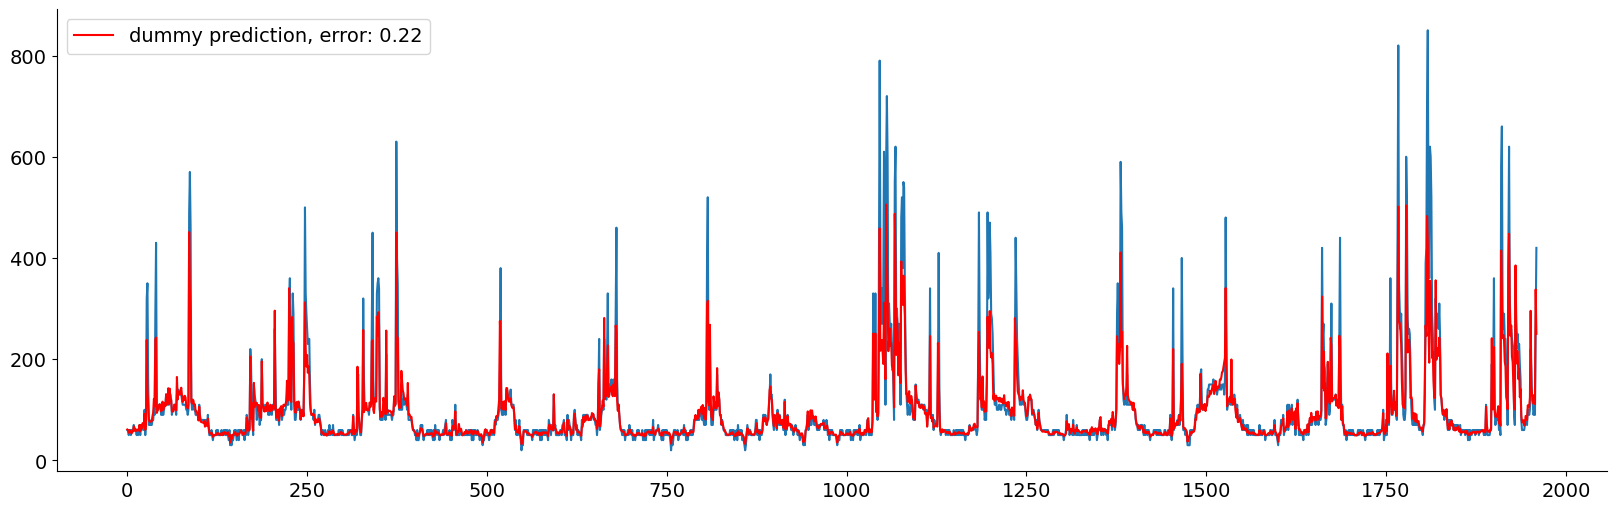

In [112]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), X_test.lag_1)
plt.plot(range(0, X_test.shape[0]), y_pred,
        color="red", label=f"dummy prediction, error: {mean_absolute_percentage_error(y_test, X_test.lag_1).round(2)}")
plt.legend()
plt.show()

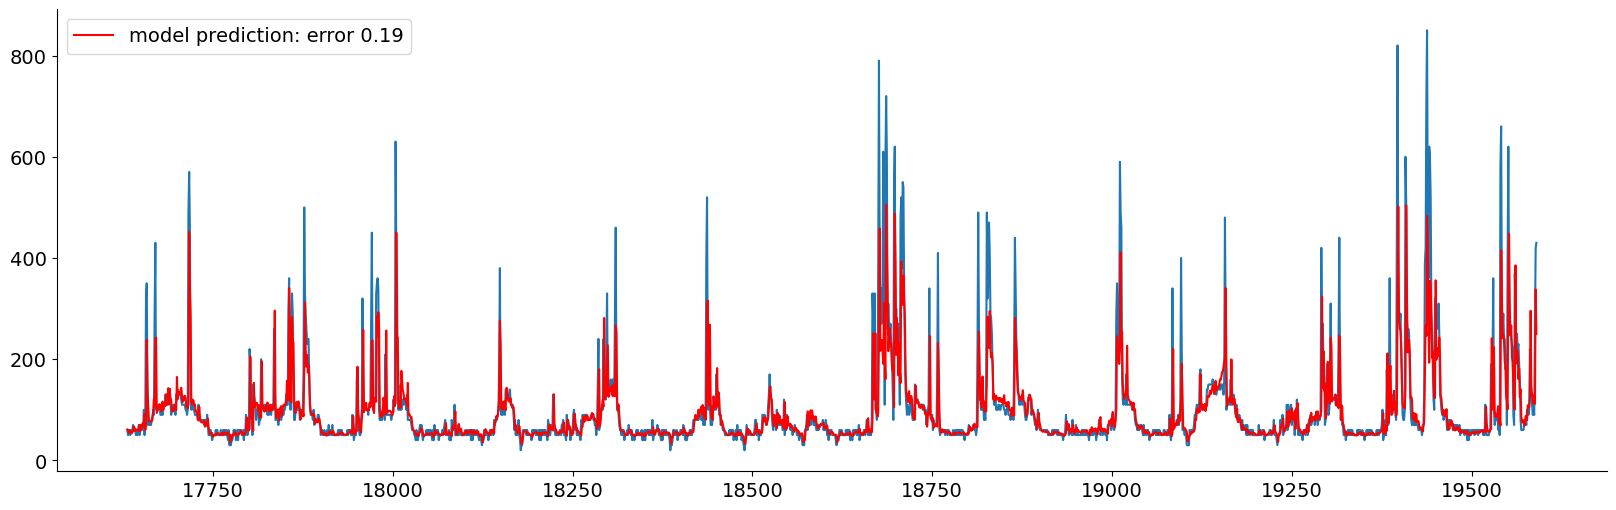

In [113]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(17631, N), data.Appliances[17631:])
plt.plot(range(n_train, N), y_pred,
        color="red", label=f"model prediction: error {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
plt.legend()
plt.show()

In [149]:
all_results = {}

for mod in [Ridge(), 
          Lasso(), 
          DecisionTreeRegressor(min_samples_leaf=50),
          ExtraTreesRegressor(min_samples_leaf=20), 
          RandomForestRegressor(min_samples_leaf=20), 
          HistGradientBoostingRegressor(),
            XGBRegressor()]:

    results = {}
    model = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), mod)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    err = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results["mape"] = err
    results["mse"] = mse
    
    all_results[model[1].__class__.__name__] = results
    
df = pd.DataFrame.from_dict(all_results, 
                            orient = "index", 
                            columns = ["mape", "mse"])

KeyboardInterrupt: 

In [140]:
df

,mape,mse
LinearRegression,0.269640,3773.874890
Ridge,0.269631,3773.870897
Lasso,0.244734,3782.825282
DecisionTreeRegressor,0.245823,3856.027515
ExtraTreesRegressor,0.227801,3483.317708
RandomForestRegressor,0.226660,3510.136789
BaggingRegressor,0.264641,3807.859274
HistGradientBoostingRegressor,0.220979,3482.322171


In [ ]:
days_to_remove = ['2016-01-27', '2016-01-28', '2016-01-29', '2016-04-01', '2016-04-02']
days_to_remove = pd.to_datetime(days_to_remove)

data = data[~data.index.normalize().isin(days_to_remove)]

### Target +24h

In [142]:
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format = "%d-%m-%Y %H:%M")
data.set_index("date", inplace = True)

data.drop(["RH_6", "rv1", "rv2"], axis=1, inplace=True)
data["day_of_week"] = data.index.day_of_week
data["hour"] = data.index.hour
data = add_lagged_features(data, lag=1, how_many=24*6)

In [143]:
data["Appliances_24"] = data.Appliances.shift(-24*6)
data.dropna(inplace=True)

/tmp/ipykernel_3449/2120256556.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Appliances_24"] = data.Appliances.shift(-24*6)


In [144]:
# data = add_lagged_features(data, lag=1, how_many=24*6)

X = data.drop(["Appliances", "Appliances_24"], axis = 1)
y = data.Appliances_24

In [145]:
n_train = int(0.95 * len(y))
X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_test, y_test = X.iloc[n_train:], y.iloc[n_train:]

In [146]:
# pipe = make_pipeline(make_column_transformer((OrdinalEncoder(), ["day_of_week"]), remainder="passthrough"), HistGradientBoostingRegressor())
model = TransformedTargetRegressor(ExtraTreesRegressor(min_samples_leaf=20), func=np.log1p, inverse_func=np.expm1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.28125383760810546

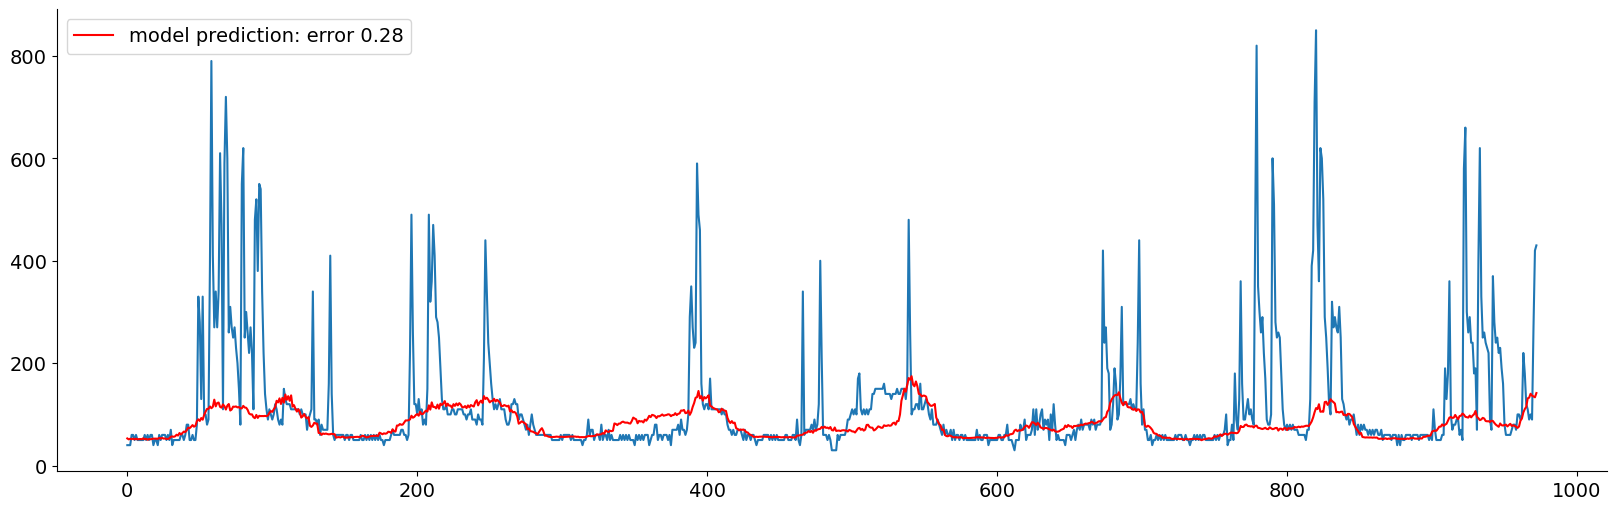

In [147]:
# N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), y_test)
plt.plot(range(0, X_test.shape[0]), y_pred,
        color="red", label=f"model prediction: error {mean_absolute_percentage_error(y_test, y_pred).round(2)}")
plt.legend()
plt.show()

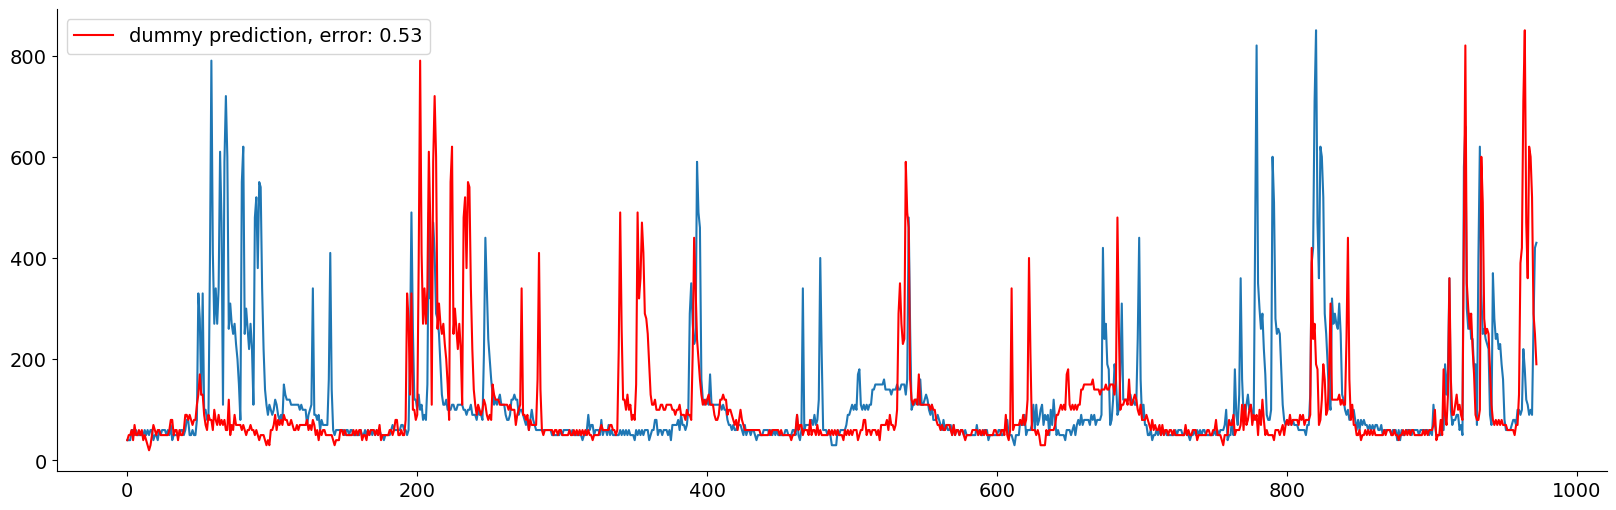

In [148]:
N = data.shape[0]
plt.figure(figsize=(20,6))
plt.plot(range(0, X_test.shape[0]), y_test)
plt.plot(range(0, X_test.shape[0]), data.Appliances.loc[X_test.index],
        color="red", label=f"dummy prediction, error: {mean_absolute_percentage_error(y_test, data.Appliances.loc[X_test.index]).round(2)}")
plt.legend()
plt.show()

In [155]:
all_results = {}

for model in [Ridge(), 
              Lasso(), 
              ExtraTreesRegressor(min_samples_leaf=20), 
              RandomForestRegressor(min_samples_leaf=20), 
              BaggingRegressor(n_estimators=100, max_samples=0.5), 
              HistGradientBoostingRegressor(),
                XGBRegressor()]:

    results = {}
    model = TransformedTargetRegressor(model, func=np.log1p, inverse_func=np.expm1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    err = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    results["mape"] = err
    results["mse"] = mse
    
    all_results[getattr(model, "regressor").__class__.__name__] = results
    
df = pd.DataFrame.from_dict(all_results, 
                            orient = "index", 
                            columns = ["mape", "mse"])

[19:17:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf" } are not used.



In [156]:
df

,mape,mse
LinearRegression,0.335495,12992.798880
Ridge,0.335487,12992.825908
Lasso,0.335483,13978.183396
DecisionTreeRegressor,0.389370,13573.762301
ExtraTreesRegressor,0.282722,12550.055209
RandomForestRegressor,0.300415,12470.285450
BaggingRegressor,0.334949,12323.615916
HistGradientBoostingRegressor,0.302742,12881.582966
XGBRegressor,0.345210,13311.871582
